(1) https://twitter.com/p_surridge/status/1254546384721756160

    -> cute thing to turn into a bokeh/holoviews interactive
    * would like to replicate basic plot 16:03
    * would like to be able to move back and forth through waves (perhaps including 2010/2005 for past vote)
    * would like to be able to change focal variable (generalElectionVote/like/ptv
    * would like to be able to change abs/relative value axes
    * would like to be able to change party pair (default Con/Lab)
    * would like to view sample size (and/or meaningful error bars)
    * would like to host as an interactive blog post
    

In [1]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na"]

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

Toggle code

var_type (7911, 14)


In [159]:
# tweak to amalgamation to make it sort by closest response date (average over waves in variable if multiwave)
# assumes that it's like al_scale/lr_scale 

def amalg_scale_by_closest_time_values(stub,mask):

    now = BES_Panel["starttimeW"+best_wave.replace("wave","")][mask].mean()
#     stub = 'al_scale'
    vars_by_time = pd.Series( {x:BES_Panel[["starttimeW"+x for x in x.replace(stub,'').split("W")[1:]]][mask].apply(lambda x: x.mean()).mean() for x in match(BES_Panel,stub).index}
                          )
    vars_by_time_relative = vars_by_time-now
    vars_by_time_relative = vars_by_time_relative.abs().sort_values(ascending=False)
    return BES_Panel[vars_by_time_relative.index][mask].apply(lambda x: x.cat.codes.replace(-1,np.nan)).fillna(method='ffill',axis=1)[vars_by_time_relative.index[-1]]

In [19]:
elec_var = "2019GEVote_complete"

LAB_or_CON19 = pan_dataset_votes[elec_var].apply( lambda x: x in ["Conservative","Labour"] )

In [11]:
best_al_scale_variable = search(BES_Panel,"al_scale",mask = LAB_or_CON19 ).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask = LAB_or_CON19 ).sort_values(ascending=False).index[0]

best_weight_variable = search(BES_Panel,"wt_",mask = LAB_or_CON19).sort_values(ascending=False).index[0]

best_al_scale_variable,best_lr_scale_variable,best_weight_variable

('al_scaleW17', 'lr_scaleW17', 'wt_new_W19_result')

In [82]:
LAB_inst_of_CON19 = pan_dataset_votes[elec_var][LAB_or_CON19] == "Conservative"

In [83]:
df = pd.concat([LAB_inst_of_CON19.astype('float32'),
           BES_Panel[best_al_scale_variable][LAB_or_CON19].cat.codes.replace(-1,np.nan),
           BES_Panel[best_lr_scale_variable][LAB_or_CON19].cat.codes.replace(-1,np.nan),
           BES_Panel[best_weight_variable][LAB_or_CON19]],axis=1)
df.columns = [elec_var,"al_scale","lr_scale","wts"]
# df=df.dropna()

In [160]:
df["al_scale"] = amalg_scale_by_closest_time_values('al_scale',mask)
df["lr_scale"] = amalg_scale_by_closest_time_values('lr_scale',mask)


In [161]:
# harmonising with Surridge schema
df["al_scale"] = (df["al_scale"]/5)-2
df["lr_scale"] = (df["lr_scale"]/5)-2

In [162]:
# df["lr_scale"].value_counts().sort_index()
replace_dict = {-2.0: "Left (-1.25)",
                -1.8: "Left (-1.25)",
                -1.6: "Left (-1.25)",
                -1.4: "Left (-1.25)",
                -1.2: "Centre-Left (-0.25)",
                -1.0: "Centre-Left (-0.25)",
                -0.8: "Centre-Left (-0.25)",
                -0.6: "Centre-Left (-0.25)",
                -0.4: "Neutral (0)",
                -0.2: "Neutral (0)",
                 0.0: "Neutral (0)",
                 0.2: "Neutral (0)",
                 0.4: "Neutral (0)",
                 0.6: "Centre-Right (0.25)",
                 0.8: "Centre-Right (0.25)",
                 1.0: "Centre-Right (0.25)",
                 1.2: "Centre-Right (0.25)",
                 1.4: "Right (1.25)",
                 1.6: "Right (1.25)",
                 1.8: "Right (1.25)",
                 2.0: "Right (1.25)",
}


In [163]:
df["lr_scale"] = df["lr_scale"].round(2).replace(replace_dict).astype('category')\
    .cat.reorder_categories(['Left (-1.25)', 'Centre-Left (-0.25)',
                             'Neutral (0)', 'Centre-Right (0.25)', 
                             'Right (1.25)'], ordered=True)

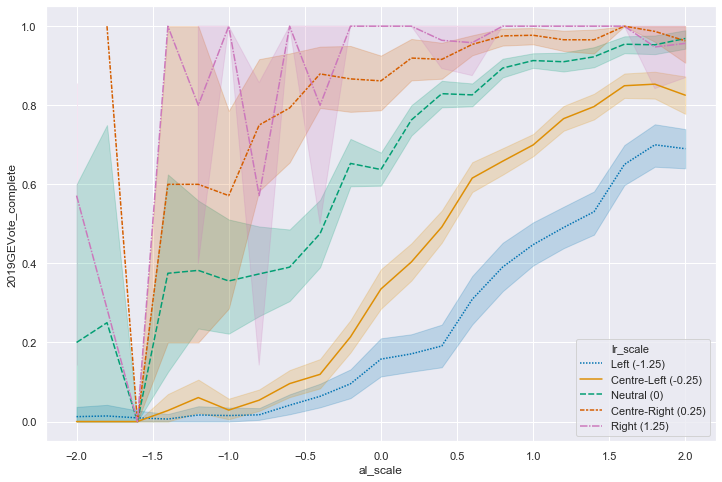

In [165]:
plt.figure(figsize=(12,8));
ax = sns.lineplot(x="al_scale", y="2019GEVote_complete",
                  hue="lr_scale", style="lr_scale", hue_order = df["lr_scale"].cat.categories, data=df)

Wall time: 2min 22s


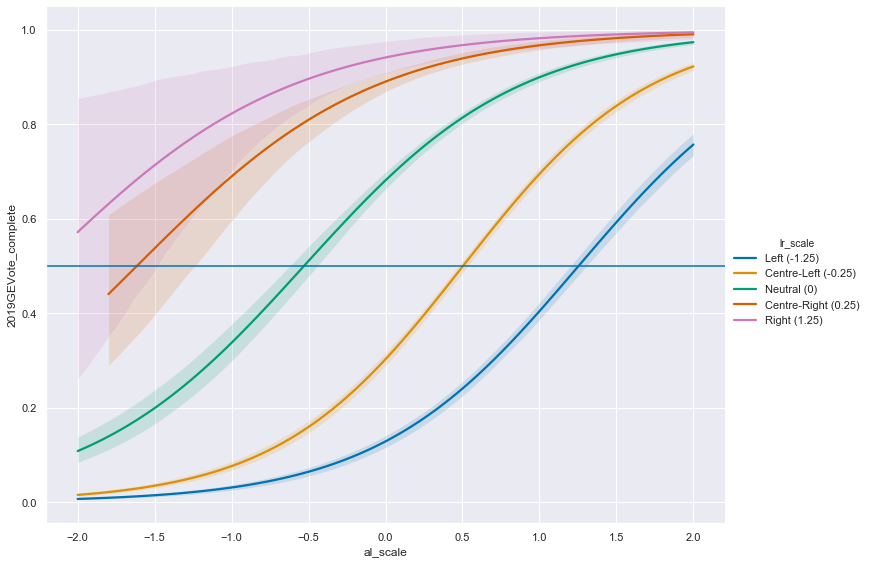

In [166]:
%%time
# plt.figure(figsize=(12,8));
ax = sns.lmplot(x="al_scale", y="2019GEVote_complete",
                  hue="lr_scale", data=df, hue_order = df["lr_scale"].cat.categories,
                  logistic=True, height = 8, aspect=1.3, scatter=False);
plt.axhline(0.5,-2,2);

Wall time: 648 ms


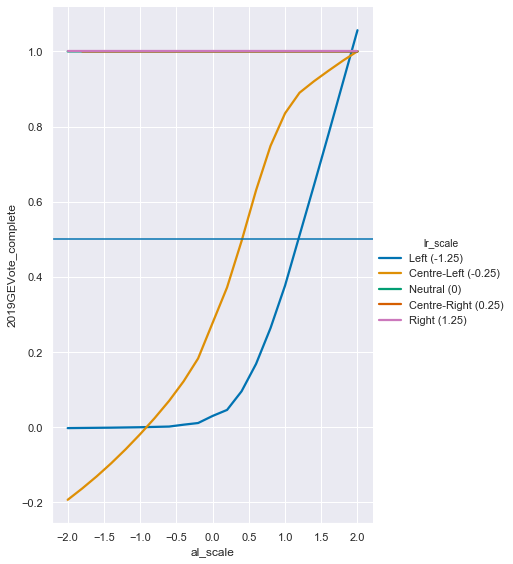

In [167]:
%%time
# plt.figure(figsize=(12,8));
ax = sns.lmplot(x="al_scale", y="2019GEVote_complete",
                  hue="lr_scale", data=df, hue_order = df["lr_scale"].cat.categories,
                  lowess=True, height = 8, aspect=.7, scatter=False);
plt.axhline(0.5,-2,2);

Wall time: 2min 21s


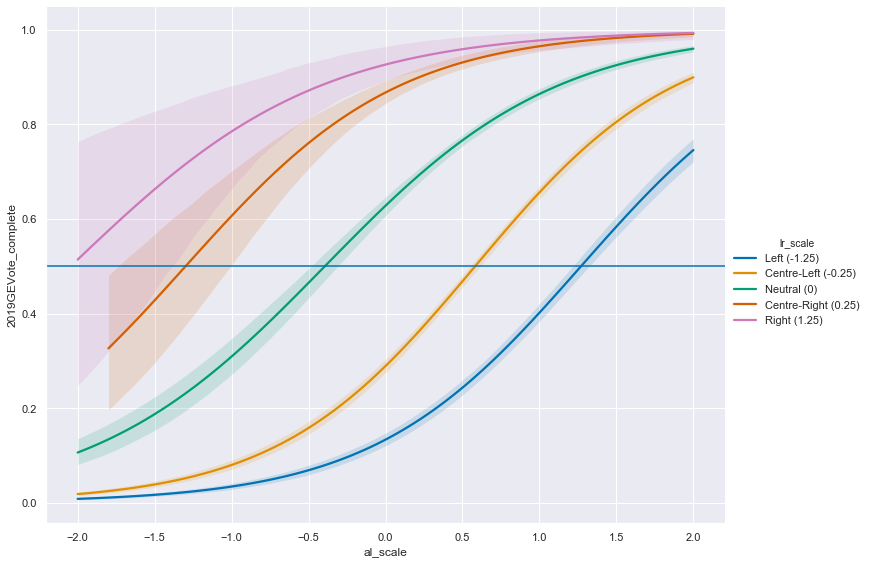

In [168]:

%%time
# plt.figure(figsize=(12,8));
ax = sns.lmplot(  x="al_scale", y="2019GEVote_complete",
                  hue="lr_scale", data=df.loc[lazy_weighted_indices(df["wts"])],
                  hue_order = df["lr_scale"].cat.categories,
                  logistic=True, height = 8, aspect=1.3, scatter=False);
plt.axhline(0.5,-2,2);

In [ ]:
# function to run an amalgamation *but ordered by distance in time*

In [86]:
df["al_scale"].isnull()

1         True
2        False
4        False
5         True
6        False
         ...  
32197    False
32198    False
32199    False
32203    False
32204     True
Name: al_scale, Length: 21343, dtype: bool

In [96]:
mask = LAB_or_CON19
best_wave = BES_Panel[match(BES_Panel,"wave\d+").index][mask].sum().sort_values(ascending=False).index[0]

In [98]:
BES_Panel["starttimeW"+best_wave.replace("wave","")][mask].mean()

Timestamp('2019-12-17 10:41:38.867109888')

In [91]:
search(BES_Panel,"time")

starttimeW1            30589
starttimeW2            30262
starttimeW3            28309
starttimeW4            31552
starttimeW5            30970
starttimeW6            30258
starttimeW7            30895
starttimeW8            33502
starttimeW9            30036
starttimeW10           30237
starttimeW11           30956
starttimeW12           34394
starttimeW13           31136
starttimeW14           31063
starttimeW15           30842
starttimeW16           37959
starttimeW17           34366
starttimeW18           37825
starttimeW19           32177
endtimeW1              30589
endtimeW2              30262
endtimeW3              28309
endtimeW4              31552
endtimeW5              30970
endtimeW6              30258
endtimeW7              30895
endtimeW8              33502
endtimeW9              30036
endtimeW10             30237
endtimeW11             30956
endtimeW12             34394
endtimeW13             31136
endtimeW14             31063
endtimeW15             30842
endtimeW16    

1        15.0
2        19.0
4        20.0
5        14.0
6        17.0
         ... 
32197    17.0
32198    12.0
32199    15.0
32203    18.0
32204    14.0
Name: al_scaleW17, Length: 21343, dtype: float64

1        15.0
2        19.0
4        20.0
5        14.0
6        17.0
         ... 
32197    17.0
32198    12.0
32199    15.0
32203    18.0
32204    14.0
Name: al_scaleW17, Length: 21343, dtype: float64

In [146]:
[vars_by_time_relative.index[-1]]

['al_scaleW17']